In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import *
from qiskit.tools.qi.qi import partial_trace, concurrence

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter, MeasurementFilter
from qiskit.quantum_info import state_fidelity

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

In [2]:
def local_measurement_circuits(input_circuit, qubit_list):
    
    ordered_qubit_list = sorted(qubit_list)
    
    cr = ClassicalRegister(len(qubit_list))
    qr = input_circuit.qregs[0]
    X = copy.deepcopy(input_circuit)
    Y = copy.deepcopy(input_circuit)
    Z = copy.deepcopy(input_circuit)
    
    X.add_register(cr)
    Y.add_register(cr)
    Z.add_register(cr)
    
    for bit_index in range(len(ordered_qubit_list)):
        
        qubit_index = ordered_qubit_list[bit_index]
        
        X.h(qr[qubit_index])
        Y.sdg(qr[qubit_index])
        Y.h(qr[qubit_index])
        
        X.measure(qr[qubit_index], cr[bit_index])
        Y.measure(qr[qubit_index], cr[bit_index])
        Z.measure(qr[qubit_index], cr[bit_index])
    
    return [X, Y, Z]

In [3]:
import numpy as np

def W_minimizer(list_of_observables):
    """
    W_minimizer accepts a list/array of five observables and returns the minimum of a general
    W-function from arXiv:1901.08102v2, appendix A. 
    """
    observables = np.array(list_of_observables, dtype=np.float32)
    
    ## check if the input is correct.
    assert len(list_of_observables)==5, "List must contain 5 observables"
    for obs in observables:
        assert -1 <= obs <= 1, "Observable not in [-1,1]"
        
    ## assign constants 
    # Form of W-function:
    # W(a) = 1/4 (1 + b + (2a^2-1)*c + (2a^2-1)*d + 2*a*Sqrt(1-a^2)*(e+f))
    
    b, c, d, e, f = [obs for obs in observables]
    
    ## W-function:
    w_a = lambda a: (1. + b + (c + d) * (2 * a**2 - 1) + (e + f) * (2 * a * np.sqrt(1 - a**2))) / 4.
    #v_a = lambda a: (1.-b**2 + (1.-c**2 + 1.-d**2) * (2 * a**2 - 1)**2 + (1.-e**2 + 1.-f**2) * (2 * a * np.sqrt(1 - a**2))**2) / 4.
    
    ## minimum of W(a)-function w.r.t. "a" (from Mathematica)
    w_min = lambda b, c, d, e, f: (1+b-np.sqrt((c+d)**2 + (e+f)**2)) / 4.
    
    ## argmin_a of w_min: (from Mathematica) 
    # defining auxillary constant 
    k = (c+d)**2 + (e+f)**2
    
    if k == 0:
        a_min = 0
    else:

        a_min_root = np.sqrt((k - c * np.sqrt(k) - d * np.sqrt(k)) / (2 * k)) ## abs value of the argmin of the Minimize function
        a_mins = [a_min_root, -a_min_root] ## take both since it is the absolute value of the argmin

        a_min = a_mins[np.argmin([w_a(a_mins[0]),w_a(a_mins[1])])] 
        
        if (a_min < -1) or (a_min > 1): ## check if a_min is out of boundary and print the corresponding parameters
            print("Warning: a_min = ",str(a_min))
            # print(b,c,d,e,f)
    
    #return "Parameters: ", (b, c, d, e, f), "Minimum: ", w_min(b,c,d,e,f), "W(a_min): ", w_a(a_min), "a_min: ", a_min
    return w_a(a_min)#, v_a(a_min)/np.sqrt(8192)

In [4]:
def ComputeWitnessAllPairs(result, qubit_list):
    
    ordered_qubit_list = sorted(qubit_list)
    nbits = len(ordered_qubit_list)
    
    counts = [result.get_counts(obs) for obs in range(3)]
    
    single_mean = {}
    for bit_index in range(nbits):
        qubit_index = ordered_qubit_list[bit_index]
        single_mean[qubit_index] = {}
        for obs in range(3):
            nshots = 0
            single_mean[qubit_index][obs] = 0.0
            for outcome in counts[obs]:
                if outcome[nbits-1-bit_index] == '0':
                    single_mean[qubit_index][obs] += counts[obs][outcome]
                else:
                    single_mean[qubit_index][obs] -= counts[obs][outcome]
                nshots += counts[obs][outcome]
            single_mean[qubit_index][obs] = float(single_mean[qubit_index][obs])/float(nshots)
    #print(single_mean)
    
    pairwise_mean = {}
    for bit_index_i in range(nbits-1):
        qubit_index_i = ordered_qubit_list[bit_index_i]
        for bit_index_j in range(bit_index_i+1, nbits):
            qubit_index_j = ordered_qubit_list[bit_index_j]
            pair = (qubit_index_i, qubit_index_j)
            pairwise_mean[pair] = {}
            for obs in range(3):
                nshots = 0
                pairwise_mean[pair][obs] = 0.0
                for outcome in counts[obs]:
                    if outcome[nbits-1-bit_index_i] == outcome[nbits-1-bit_index_j]:
                        pairwise_mean[pair][obs] += counts[obs][outcome]
                    else:
                        pairwise_mean[pair][obs] -= counts[obs][outcome]
                    nshots += counts[obs][outcome]
                pairwise_mean[pair][obs] = float(pairwise_mean[pair][obs])/float(nshots)
    #print(pairwise_mean)


    entanglement_witness = {}
    for bit_index_i in range(nbits-1):
        qubit_index_i = ordered_qubit_list[bit_index_i]
        for bit_index_j in range(bit_index_i+1, nbits):
            qubit_index_j = ordered_qubit_list[bit_index_j]
            pair = (qubit_index_i, qubit_index_j)
            
            xi = single_mean[qubit_index_i][0]
            ix = single_mean[qubit_index_j][0]
            yi = single_mean[qubit_index_i][1]
            iy = single_mean[qubit_index_j][1]
            zi = single_mean[qubit_index_i][2]
            iz = single_mean[qubit_index_j][2]
            
            xx = pairwise_mean[pair][0]
            yy = pairwise_mean[pair][1]
            zz = pairwise_mean[pair][2]

            a = np.zeros((6,5))
            a[0] = [zz, xx, yy, zi, iz]
            a[1] = [-zz, xx, -yy, zi, -iz]
            a[2] = [xx, zz, yy, xi, ix]
            a[3] = [-xx, zz, -yy, -xi, ix]
            a[4] = [yy, zz, xx, yi, iy]
            a[5] = [-yy, zz, -xx, -yi, iy]

            W_mins = [W_minimizer(a[i]) for i in range(6)]
            #print(W_mins)
            abs_min = min(W_mins)
            entanglement_witness[pair] = (abs_min < -1.0/np.sqrt(float(nshots)), abs_min)
    
    return entanglement_witness

In [5]:
def GraphState(edges):
    
    qlist = []
    for edge in edges:
        if edge[0] not in qlist:
            qlist.append(edge[0])
        if edge[1] not in qlist:
            qlist.append(edge[1])
    
    q = QuantumRegister(len(qlist))
    graph = QuantumCircuit(q)
    
    for qubit_index in qlist:
        graph.h(q[qubit_index])
    
    for edge in edges:
        graph.h(q[edge[1]])
        graph.cx(q[edge[0]], q[edge[1]])
        graph.h(q[edge[1]])

    return graph

In [15]:
def Darwin(n, l, t, theta):
    
    qr = QuantumRegister(2*n+1)
    darwin = QuantumCircuit(qr)
    
    p = 1.0 - np.exp(-l*t)
    phase = 2.0*np.arcsin(np.sqrt(p))
    print(p,phase, np.sin(phase/2.0)**2)
    
    darwin.h(qr[2*n])
    for emitter in range(0,2*n,2):
        darwin.ry(phase, qr[emitter])
        darwin.cx(qr[emitter], qr[emitter+1])
        darwin.x(qr[emitter+1])
        darwin.h(qr[emitter+1])
        darwin.rz(-theta/2.0, qr[2*n])
        darwin.rz(-theta/2.0, qr[emitter+1])
        darwin.crz(theta/1.0, qr[2*n], qr[emitter+1])
        darwin.crz(theta/1.0, qr[emitter+1], qr[2*n])
        darwin.h(qr[emitter+1])
    darwin.h(qr[2*n])
    
    return darwin

0.9999546000702375 3.1281166576221096 0.9999546000702376


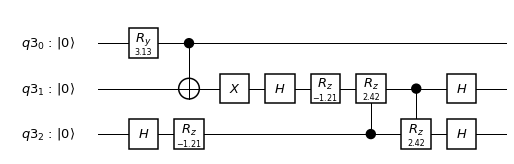

In [16]:
#q = QuantumRegister(5)
#test_circ = QuantumCircuit(q)
#test_circ.x(q[0])
#test_circ.x(q[0])
#test_circ.h(q[0])
#test_circ.ry(0.05,q[0])
#test_circ.h(q[0])
#test_circ.s(q[0])
#test_circ.cx(q[0],q[1])

#test_circ = GraphState([(0,1), (1,2), (3,4), (4,5), (1,4)])
#test_circ = GraphState([(0,1), (1,2), (0,2)])
#test_circ = GraphState([(0,1)])
#test_circ.h(test_circ.qregs[0][2])

test_circ = Darwin(1, 10., 1.0, 1.0*np.pi/1.30)
qlist = list(range(len(test_circ.qregs[0])))
#lmc = local_measurement_circuits(test_circ, qlist)

test_circ.draw(output = 'mpl')


In [17]:
job_state_vec = execute(test_circ, Aer.get_backend('statevector_simulator'))
state_vec = job_state_vec.result().get_statevector()

conc = {}
n = len(qlist)
for i in range(n-1):
    for j in range(i+1, n):
        qpt = qlist[:]
        qpt.remove(i)
        qpt.remove(j)
        part = partial_trace(state_vec, qpt)
        conc[(i,j)] = (concurrence(part) > 1e-5, concurrence(part))
conc

{(0, 1): (True, 0.09943009484123723),
 (0, 2): (True, 0.056259221960011055),
 (1, 2): (True, 0.8941248102156978)}

In [ ]:
nshots = 8192
backend = Aer.get_backend('qasm_simulator')
job = execute(lmc, backend=backend, shots = nshots)
job_result = job.result()
ComputeWitnessAllPairs(job_result, qlist)

In [ ]:
print(job_result.get_counts(2))

In [ ]:
def W_a(av, a):
    
    return 0.25*(1.0 + av[0] + (av[1] + av[2])*(2.0*a**2-1.0) + (av[3]+av[4])*(2.0*a*np.sqrt(1.0-a**2)))

ix, xi = 0.,0.
iy, yi = 0.,0.
iz, zi = 0.,0.
xx = -1.
yy = -1.
zz = -1.

al = np.zeros((6,5))
al[0] = [zz, xx, yy, zi, iz]
al[1] = [-zz, xx, -yy, zi, -iz]
al[2] = [xx, zz, yy, xi, ix]
al[3] = [-xx, zz, -yy, -xi, ix]
al[4] = [yy, zz, xx, yi, iy]
al[5] = [-yy, zz, -xx, -yi, iy]

a_vals = np.linspace(-1.0, 1.0, 100)
for i in range(6):
    y_vals = W_a(al[i], a_vals)
    plt.plot(a_vals, y_vals, label = str(i))
plt.legend()

In [ ]:
from qiskit.tools.qi.qi import concurrence

In [ ]:
concurrence(np.array([1.,0.,0.,-1.]/np.sqrt(2.0)))

In [ ]:
N = 1000
nlayers = int(np.ceil(np.log(float(N))/np.log(3.0)))
print(nlayers)
pairs = {}
obs = ["X", "Y", "Z"]
for one in range(3):
    for two in range(2):
        obs_copy = obs[:]
        sequence = [obs_copy[one]]
        obs_copy.remove(obs_copy[one])
        sequence.append(obs_copy[two])
        obs_copy.remove(obs_copy[two])
        sequence.append(obs_copy[0])
        
        for layout in range(nlayers):
            c = {}
            for qubit in range(N):
                q_index = int(float(qubit)/float(3**layout))%3
                c[qubit] = sequence[q_index]
        
            for i in range(N-1):
                q_index_i = int(float(i)/float(3**layout))%3
                for j in range(i+1,N):
                    q_index_j = int(float(j)/float(3**layout))%3
                    pair = (i,j)
                    if pair not in pairs:
                        pairs[pair] = []
                    if q_index_i != q_index_j and (c[i],c[j]) not in pairs[pair]:
                        pairs[pair].append((c[i],c[j]))



In [ ]:
pos = [('X','Y'),('X','Z'),('Y','X'),('Y','Z'),('Z','X'),('Z','Y')]
for pair in pairs:
    if len(pairs[pair]) != 6:
        print("Length error", pair)
    pos_copy = pos[:]
    for el in pairs[pair]:
        pos_copy.remove(el)
    if len(pos_copy) > 0:
        print("Oops", pair)
    

In [ ]:
pairs

In [3]:
def pairwise_state_tomography_circuits(input_circuit, qubit_list):
    
    ### Initialisation stuff
    ordered_qubit_list = sorted(qubit_list)
    N = len(qubit_list)
    
    cr = ClassicalRegister(len(qubit_list))
    qr = input_circuit.qregs[0]
    
    
    ### Uniform measurement settings
    X = copy.deepcopy(input_circuit)
    Y = copy.deepcopy(input_circuit)
    Z = copy.deepcopy(input_circuit)
    
    X.add_register(cr)
    Y.add_register(cr)
    Z.add_register(cr)
    
    X.name = ('X',)*N
    Y.name = ('Y',)*N
    Z.name = ('Z',)*N
    
    for bit_index in range(len(ordered_qubit_list)):
        
        qubit_index = ordered_qubit_list[bit_index]
        
        X.h(qr[qubit_index])
        Y.sdg(qr[qubit_index])
        Y.h(qr[qubit_index])
        
        X.measure(qr[qubit_index], cr[bit_index])
        Y.measure(qr[qubit_index], cr[bit_index])
        Z.measure(qr[qubit_index], cr[bit_index])
    
    output_circuit_list = [X, Y, Z]
    
    
    ### Heterogeneous measurement settings
    # Generation of six possible sequences
    sequences = []
    meas_bases = ['X', 'Y', 'Z']
    for i in range(3):
        for j in range(2):
            meas_bases_copy = meas_bases[:]
            sequence = [meas_bases_copy[i]]
            meas_bases_copy.remove(meas_bases_copy[i])
            sequence.append(meas_bases_copy[j])
            meas_bases_copy.remove(meas_bases_copy[j])
            sequence.append(meas_bases_copy[0])
            sequences.append(sequence)
    
    # Qubit colouring
    nlayers = int(np.ceil(np.log(float(N))/np.log(3.0)))
    pairs = {}
    for layout in range(nlayers):
        for sequence in sequences:
            meas_layout = copy.deepcopy(input_circuit)
            meas_layout.add_register(cr)
            meas_layout.name = ()
            for bit_index in range(N):
                qubit_index = ordered_qubit_list[bit_index]
                local_basis = sequence[int(float(bit_index)/float(3**layout))%3]
                if local_basis == 'Y':
                    meas_layout.sdg(qr[qubit_index])
                if local_basis != 'Z':
                    meas_layout.h(qr[qubit_index])
                meas_layout.measure(qr[qubit_index], cr[bit_index])
                meas_layout.name += (local_basis,)
            output_circuit_list.append(meas_layout)
    
    return output_circuit_list

In [11]:
q = QuantumRegister(20)
test_circ = QuantumCircuit(q)
qlist = list(range(20))

meas_circs = pairwise_state_tomography_circuits(test_circ, qlist)

In [12]:
for i, c in enumerate(meas_circs):
    print(i,c.name)
    print("#"*40)

0 ('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X')
########################################
1 ('Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y')
########################################
2 ('Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z')
########################################
3 ('X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y')
########################################
4 ('X', 'Z', 'Y', 'X', 'Z', 'Y', 'X', 'Z', 'Y', 'X', 'Z', 'Y', 'X', 'Z', 'Y', 'X', 'Z', 'Y', 'X', 'Z')
########################################
5 ('Y', 'X', 'Z', 'Y', 'X', 'Z', 'Y', 'X', 'Z', 'Y', 'X', 'Z', 'Y', 'X', 'Z', 'Y', 'X', 'Z', 'Y', 'X')
########################################
6 ('Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y', 'Z')
#################################

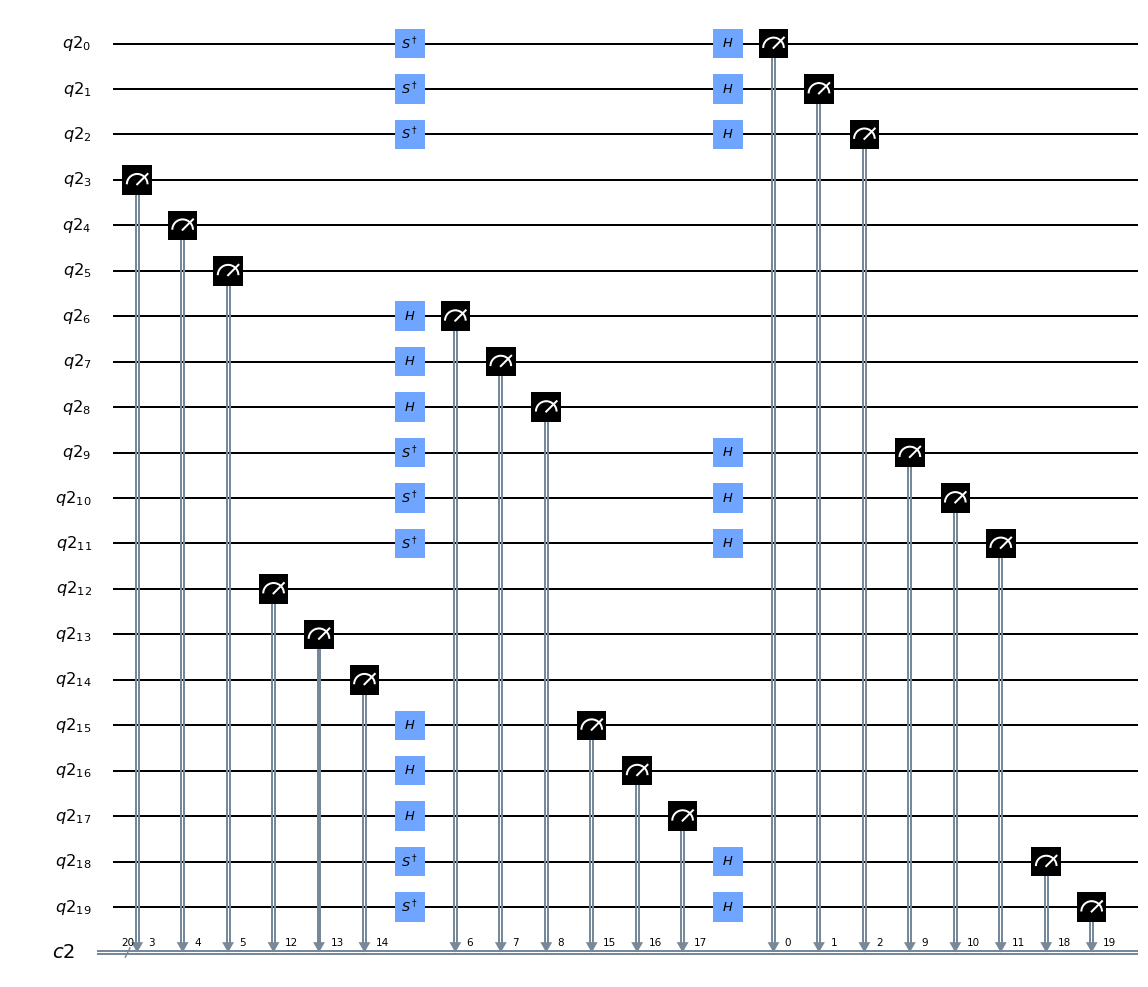

In [13]:
meas_circs[12].draw(output='mpl')